# Regularization Demo
In this notebook, we'll explore different aspects of regularization. 

First, we generate a nonlinear model for input x and output y. We'll try to fit a linear regression model with this nonlinear model using different polynomials of x. Second, we are going to use L1 and L2 regularization in the linear regression model to see the impacts on overfitting. We'll also explore different properties of L1 and L2 regularization. Finally, We'll use support vector regressor, and compare the results from all of our regressor.

Let us import related packages for this regression and visualization.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVR

from IPython.core.pylabtools import figsize
figsize(18, 6)

## Model and the Noisy data
Now, we generate a test data. The model of this test data is a sine wave, and we add a small Gaussian noise. Our main goal will be come up with a regression model, which will fit the model rather than over fitting with the noisy data point.

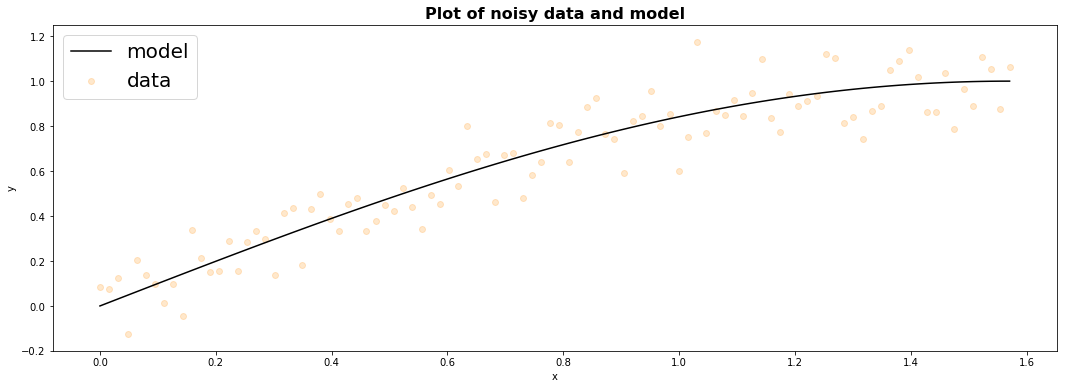

In [18]:
N=100
x=2*np.pi*np.linspace(0,0.25,N)
ymodel=np.sin(x)
y=ymodel+np.random.normal(0,0.1,N)

def plot_data_model(title):
    plt.scatter(x,y,alpha=0.2,color='darkorange',label='data')
    plt.plot(x,ymodel,color='k',label='model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title, fontweight='bold',fontsize=16)
    plt.legend(prop={'size':20})
    plt.show()

plot_data_model('Plot of noisy data and model')

## Estimation using different model complexity
### Estimation vs Model complexity
Now, we'll create models using different polynomials of the input and build linear models using those input polynomials. Model complexity N means using up to N-th input polynomials for the linear regressor. Here, we are expecting that the estimation will overfit the data when higher model complexity is in play.

Let us verify the theoretical understanding.

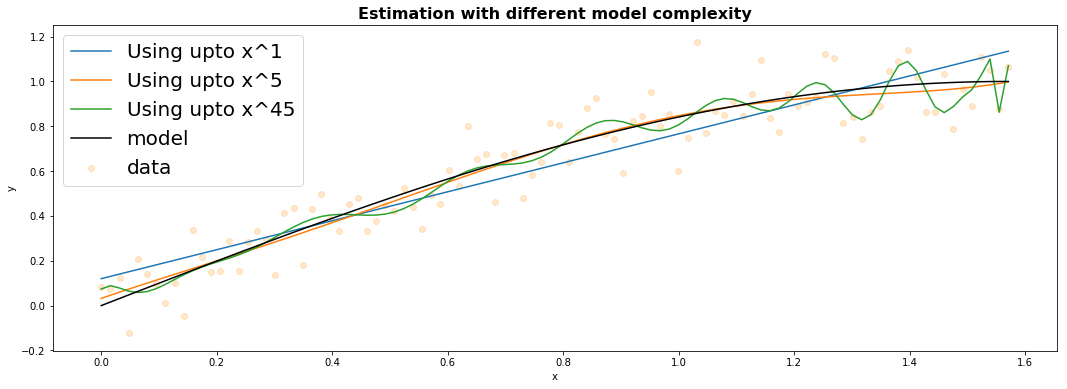

In [19]:
### Linear Regression fiting
model=45
X=np.zeros((N,model))
for i in range(1,model):
    X[:,i-1]=pow(x,i)

error=[]
dev=[]
for i in range(1,model+1):
    model=linear_model.LinearRegression()
    model.fit(X[:,0:i],y)
    yest=model.predict(X[:,0:i])
    error.append(np.mean((y-yest)**2))
    dev.append(np.mean((ymodel-yest)**2))
    if i in [1,5,45]:
        plt.plot(x,yest,label='Using upto x^%d'%i)

plot_data_model('Estimation with different model complexity')

### Deviation from model and noisy data for different model complexity
As we increase the model complexity, we see that the estimation error with respect to the noisy data is decreasing, and the estimation error from the model values is increasing. This implies that our estimation overfits the noisy data when higher model complexity is employed.

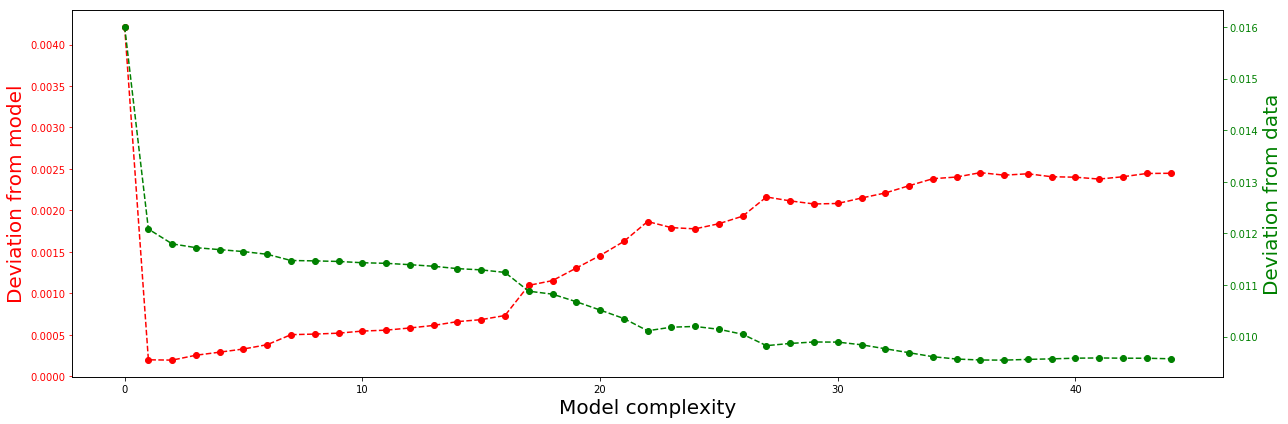

In [20]:
fig, ax1 = plt.subplots()
ax1.plot(dev,'o',ls='--',color='r',label='Model deviation')
ax1.set_ylabel('Deviation from model', color='r', fontsize=20)
ax1.tick_params('y', colors='r')
ax1.set_xlabel('Model complexity',fontsize=20)

ax2 = ax1.twinx()
ax2.plot(error,'o',ls='--',color='g',label='Data deviation')
ax2.set_ylabel('Deviation from data', color='g',fontsize=20)
ax2.tick_params('y', colors='g')
fig.tight_layout()
plt.show()

## Reduce overfiting using regularization
Now, we are going to use L1 and L2 regularization to reduce overfitting of the regressor. We'll use all polynomial of x, which means the highest model complexity is taken into account. Therefore, the linear estimation will provide an overfitted estimation. 

The L1 and L2 regularization is deployed to reduce the overfitting.
 We'll see that L1 and L2 regularization reduce the overfitting effect, and fit the regressor closely to the model rather than the noisy data.

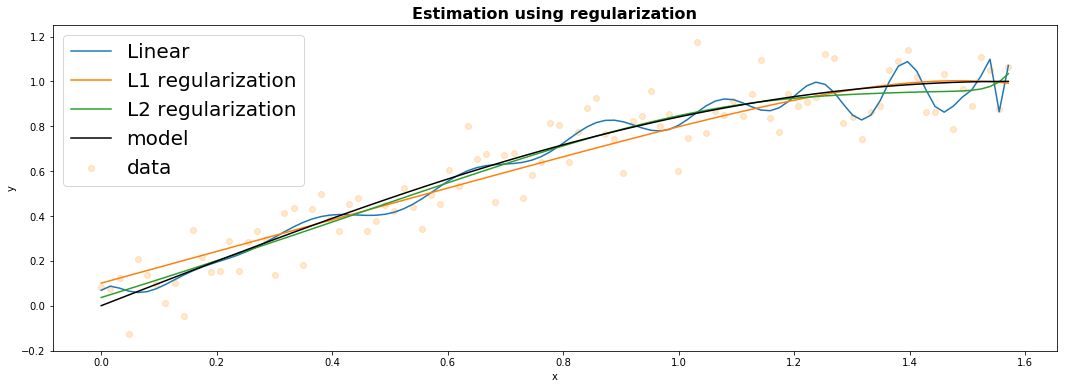

In [21]:
bag_of_regressor=[{'model':linear_model.LinearRegression(),'name':'Linear'},
                  {'model':linear_model.Lasso(max_iter=1e5,normalize=True, alpha=1e-3),'name':'L1 regularization'},
                  {'model':linear_model.Ridge(normalize=True,alpha=1e-3),'name':'L2 regularization'}
                  ]

for regressor in bag_of_regressor:
      model=regressor['model'].fit(X,y)
      yest=model.predict(X)
      plt.plot(x,yest,label=regressor['name'])

plot_data_model('Estimation using regularization')

## Deviation from data and model for different alphas
From the previous figure, we see that the linear regressor overfit the noisy data. Therefore, it takes curvy shape to fit each data instance. The L1 and L2 regularization remove the curvy trend and try to fit the regressor more towards the model.

One important thing to note that the regularization parameter (alpha) plays a big role on how much weights we will put on regularization. The very large value of alpha will introduce unexpectable bias, and very low value of alpha will neglect the regularization effect.

Let us see, how the estimation deviate from the data and the model when the regularization coefficient varies.

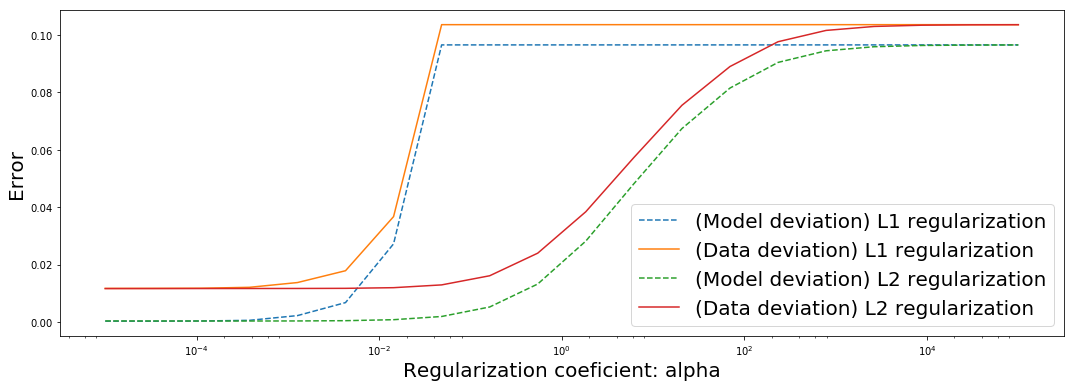

In [22]:
n_alphas = 20
alphas = np.logspace(-5, 5, n_alphas)
plt.figure()

coefs=[]
for regressor in bag_of_regressor[1:]:
    dev=[]
    error=[]
    coef=[]
    for a in alphas:
        model=regressor['model']
        model.set_params(alpha=a)
        model.fit(X,y)
        yest=model.predict(X)
        dev.append(np.mean((ymodel-yest)**2))
        error.append(np.mean((y-yest)**2))
        coef.append(model.coef_)
        
    coefs.append(coef)
    plt.plot(alphas,dev,ls='--',label='(Model deviation) '+regressor['name'])
    plt.plot(alphas,error,label='(Data deviation) '+regressor['name'])
    
plt.xscale('log')
plt.xlabel('Regularization coeficient: alpha', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.legend(prop={'size':20})
plt.show()

## Number of zero coefficient in L1 and L2 regularization
From the previous figure, we see that for large regularization coefficient the error become a fixed value when the highest amount of bias is added. 

Now, we are going to check how many coefficients become zero for L1 and L2 regularization. From the next figure, we see that number of zero coefficient is increased for a larger value of alpha when L1 regularization is used. L1 regularization uses almost all polynomial of x. Therefore, L1 produces sparse solutions, and suitable for feature selection. L2 includes all features given to the regressor. Therefore, it is not useful for a humongous number of features and prone to computational challenge.

On the other hand, L1 regression is not good when highly correlated features are involved. From the figure, we see that the L1 regressor assign so many features to zero. Another point is that L2 regressor work for a large range of alphas, where L1 deviate away from the model for a smaller range of alphas. Therefore, we can say that L2 provide the more robust estimation. 

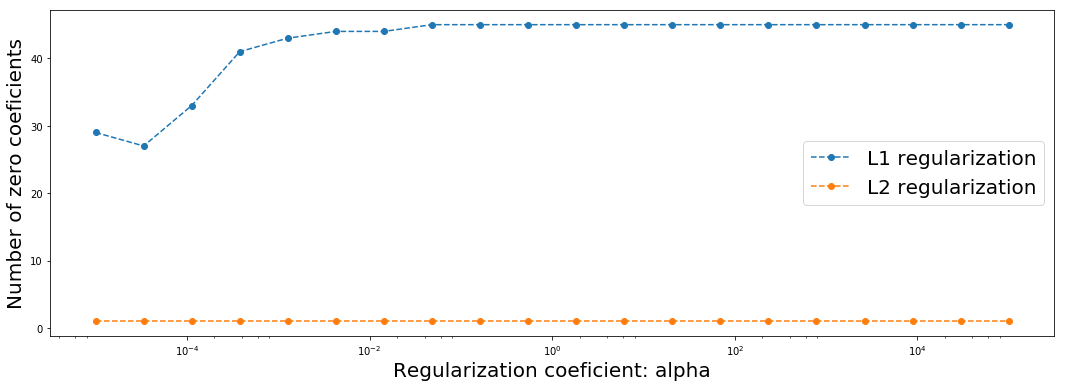

In [23]:
plt.figure()
for c,regressor in zip(coefs,bag_of_regressor[1:]):
    c=np.array(c)
    plt.plot(alphas,np.sum(c==0,axis=1),'o',ls='--',label=regressor['name'])
plt.xscale('log')
plt.xlabel('Regularization coeficient: alpha', fontsize=20)
plt.ylabel('Number of zero coeficients', fontsize=20)
plt.legend(prop={'size':20})
plt.show()

## L1 and L2 regularization coeficients values
Plotting of weights from L1 and L2 regressor will also support our previous conclusions. 
* L1 regressor puts higher weights to a few coefficients.
* L1 produces sparse solution than L2.
* L2 assign higher values on multiple weights, and in general, has larger weights than L1.
* L2 provide a wider range of alphas and provide a robust estimation.

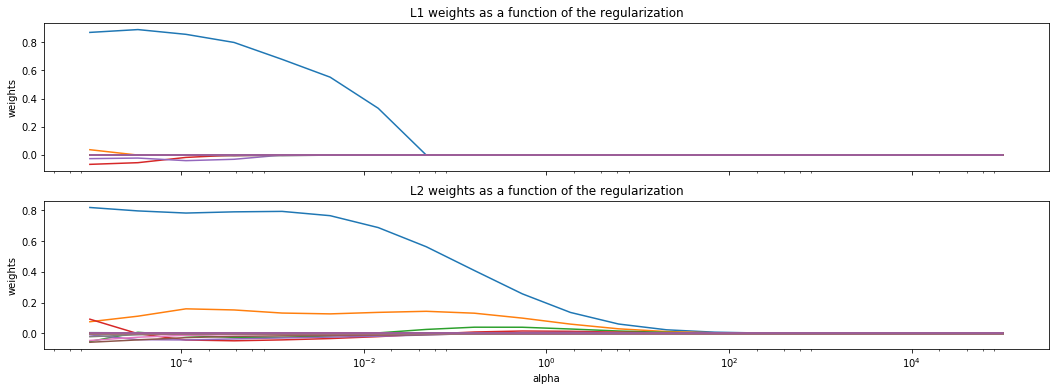

In [24]:
fig,subplot=plt.subplots(2,1,sharex=True)
ax =subplot[0]

ax.plot(alphas,coefs[0])
ax.set_xscale('log')
ax.set_title('L1 weights as a function of the regularization')
ax.set_ylabel('weights')

ax=subplot[1]

ax.plot(alphas,coefs[1])
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')

ax.set_title('L2 weights as a function of the regularization')
plt.axis('tight')
plt.show()

### Estimation error for different alphas and model complexities
Now, we are going to examine the estimation error of L1 and L2 regularization for different values of alphas and different model complexities. From the below figure, we can see that L1 regularization performance varies more than L2 regularization for different value of alphas and model complexities. Therefore, we can conclude that L2 provide more robust, computationally complex, and less sparse solution than L1.

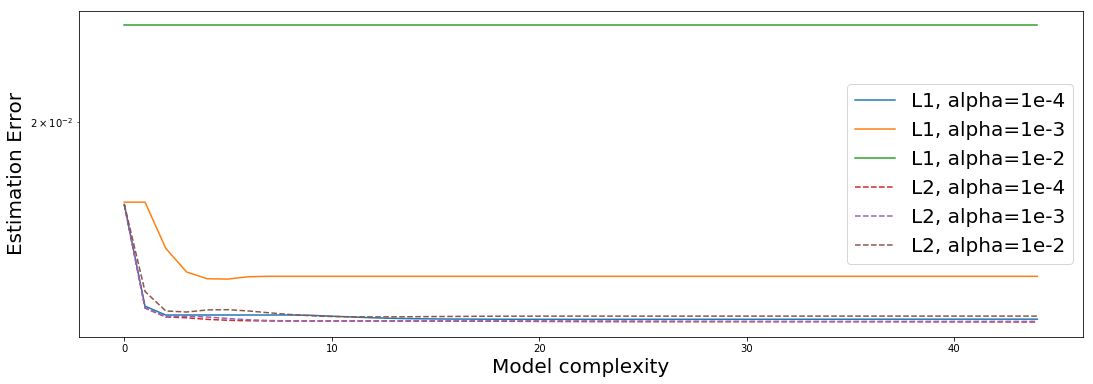

In [25]:
bag_of_regressor=[{'model':linear_model.Lasso(max_iter=1e5,normalize=True, alpha=1e-4),'name':'L1, alpha=1e-4'},
                  {'model':linear_model.Lasso(max_iter=1e5,normalize=True, alpha=1e-3),'name':'L1, alpha=1e-3'},
                  {'model':linear_model.Lasso(max_iter=1e5,normalize=True,alpha=1e-2),'name':'L1, alpha=1e-2'},
                  {'model':linear_model.Ridge(max_iter=1e5,normalize=True,alpha=1e-4),'name':'L2, alpha=1e-4'},
                  {'model':linear_model.Ridge(max_iter=1e5,normalize=True,alpha=1e-3),'name':'L2, alpha=1e-3'},
                  {'model':linear_model.Ridge(max_iter=1e5,normalize=True,alpha=1e-2),'name':'L2, alpha=1e-2'}
                  ]
for regressor, k in zip(bag_of_regressor,range(0,len(bag_of_regressor))):
    error=[]
    model=regressor['model']
    for i in range(1,46):
        model.fit(X[:,0:i],y)
        yest=model.predict(X[:,0:i])
        error.append(np.mean((y-yest)**2))
    if k<3:
        plt.plot(error,label=regressor['name'])
    else:
        plt.plot(error,ls='--',label=regressor['name'])
    
plt.yscale('log')
plt.xlabel('Model complexity', fontsize=20)
plt.ylabel('Estimation Error', fontsize=20)
plt.legend(prop={'size':20})
plt.show()

### MSE for a bag of regressor
This is just an example of how to use Support Vector Regressor and Regularization. This output does not conclude the performance of these regressor. Because performance is subject to proper parameter tuning. 

MSE(Linear): 0.000290
MSE(L1, alpha=1e-4): 0.000252
MSE(L2, alpha=1e-4): 0.000203
MSE(SVR-RBF): 0.001438
MSE(SVR-linear): 0.000164
MSE(SVR-poly): 0.000755


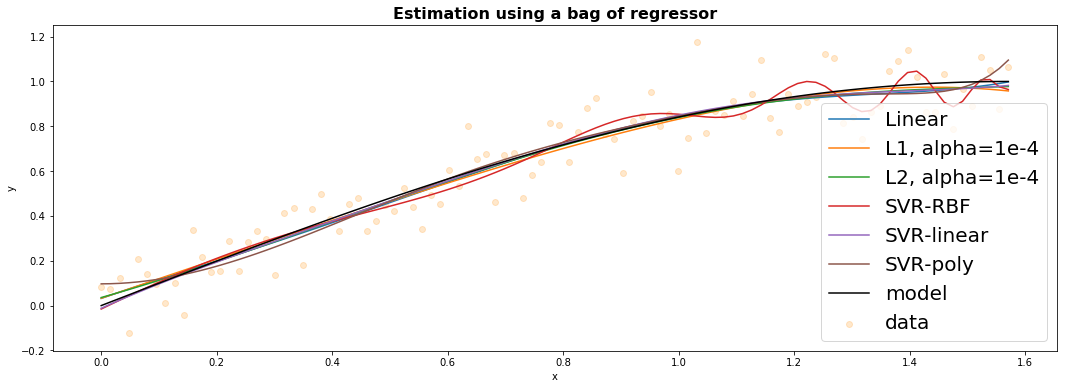

In [26]:
bag_of_regressor=[{'model':linear_model.LinearRegression(),'name':'Linear'},
                  {'model':linear_model.Lasso(max_iter=1e5,normalize=True, alpha=1e-4),'name':'L1, alpha=1e-4'},
                  {'model':linear_model.Ridge(max_iter=1e5,normalize=True,alpha=1e-4),'name':'L2, alpha=1e-4'},
                  {'model':SVR(kernel='rbf', C=1e3, gamma=0.1), 'name':'SVR-RBF'},
                  {'model':SVR(kernel='linear', C=1e3), 'name':'SVR-linear'},
                  {'model':SVR(kernel='poly', C=1e3,degree=2), 'name':'SVR-poly'}
                  ]

for regressor in bag_of_regressor:
      model=regressor['model'].fit(X[:,0:5],y)
      yest=model.predict(X[:,0:5])
      plt.plot(x,yest,label=regressor['name'])
      print("MSE("+regressor['name']+"): %f"%np.mean((ymodel-yest)**2))

plot_data_model('Estimation using a bag of regressor')

Thank you!